In [1]:
axis_pair8,axis_pair6,axis_pair4,axis_pair0 = [],[],[],[]
area8,area6,area4,area0 =  [],[],[],[]
maxMPS_list, centroidMPS_list,centroid_Brain = [], [],[]
vec1_list, vec2_list = [], []
volume = []

In [396]:
import NewCore
import os
os.chdir('/Volumes/FAIR/DC-Image-Analysis/DC-project-master/cleancode/NewMidplane')
import Functions
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
from scipy.ndimage.interpolation import rotate
%matplotlib inline


from scipy.ndimage.morphology import binary_opening as bo
from scipy.ndimage.morphology import binary_erosion as be
from scipy.ndimage.morphology import binary_closing as bc
from scipy.ndimage.morphology import binary_fill_holes as bfh

import skimage
from skimage import filters

 
def BiggestRegion(array):
    labels,num = skimage.measure.label(array, connectivity=3,return_num='Ture')
    if num>1:
        props = skimage.measure.regionprops(labels)
        b = [p.area for p in props]
        ind = b.index(max(b))
        bcoords = props[ind].coords
        b_loop = np.zeros((array.shape))
        for i in range(len(bcoords)):
                a,b,c = bcoords[i]
                b_loop[a,b,c]=1
    else:
        b_loop = array
        
    return b_loop

from ipywidgets import interact, fixed
from IPython.display import display

def wl_to_lh(window, level):
    low = level - window/2
    high = level + window/2
    return low,high

import skimage
from skimage import filters

def display_image(img, x=None, y=None, z=None, window=None, level=None):
    # Convert SimpleITK image to NumPy array
    img_array = sitk.GetArrayFromImage(img)
    
    # Get image dimensions in millimetres
    size = img.GetSize()
    spacing = img.GetSpacing()
    width  = size[0] * spacing[0]
    height = size[1] * spacing[1]
    depth  = size[2] * spacing[2]
    
    if x is None:
        x = np.floor(size[0]/2).astype(int)
    if y is None:
        y = np.floor(size[1]/2).astype(int)
    if z is None:
        z = np.floor(size[2]/2).astype(int)
    
    if window is None:
        window = np.max(img_array) - np.min(img_array)
    
    if level is None:
        level = window / 2 + np.min(img_array)
    
    low,high = wl_to_lh(window,level)

    # Display the orthogonal slices
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

    ax1.imshow(img_array[z,:,:], cmap='gray', clim=(low, high), extent=(0, width, height, 0))
    ax2.imshow(img_array[:,y,:], origin='lower', cmap='gray', clim=(low, high), extent=(0, width,  0, depth))
    ax3.imshow(img_array[:,:,x], origin='lower', cmap='gray', clim=(low, high), extent=(0, height, 0, depth))

    # Additionally display crosshairs
    ax1.axhline(y * spacing[1], lw=1)
    ax1.axvline(x * spacing[0], lw=1)
    
    ax2.axhline(z * spacing[2], lw=1)
    ax2.axvline(x * spacing[0], lw=1)
    
    ax3.axhline(z * spacing[2], lw=1)
    ax3.axvline(y * spacing[1], lw=1)

    plt.show()
    
def reshape(array, ConstPixelSpacing):
    """ Reshape array to have cubic voxels of size 1mm^3 """
    '''mind the a, b, c value is adjusted to make each '''

    width = array.shape[0]
    height = array.shape[1]
    depth = array.shape[2]
    a = int((width)*ConstPixelSpacing[0])
    b = int((height)*ConstPixelSpacing[1])
    c = int((depth)*ConstPixelSpacing[2])
    reshapedArray1 = np.zeros((a,height,depth))
    xp = np.linspace(0, (width-1)*ConstPixelSpacing[0], width) #adjust xp as [0,1ConstPixelSpacing,2CPS..
    x  = np.linspace(0, a-1, a)

    for j in range(height):
        for k in range(depth):
            reshapedArray1[:,j,k] = np.interp(x, xp, array[:,j,k])
    reshapedArray2 = np.zeros((a,b,depth))
    yp = np.linspace(0,(height-1)*ConstPixelSpacing[1],height)
    y = np.linspace(0,b-1,b)
    for j in range(a):
        for k in range(depth):
            reshapedArray2[j,:,k] = np.interp(y, yp, reshapedArray1[j,:,k])
    reshapedArray3 = np.zeros((a,b,c))
    zp = np.linspace(0,(depth-1)*ConstPixelSpacing[2],depth)
    z = np.linspace(0,c-1,c)
    for j in range(a):
        for k in range(b):
            reshapedArray3[j,k,:] = np.interp(z, zp, reshapedArray2[j,k,:])
    return reshapedArray3
    


def saveImage(array,img):
    array = np.swapaxes(array,0,2)
    mask = sitk.GetImageFromArray(array)
    mask.CopyInformation(img)
    sitk.WriteImage(mask, os.path.split(path)[0] + '/ROI.nii.gz')


In [397]:
paths = ['/Volumes/FAIR/Eric_Midlinedeliniation/Self-MPS/SDH2/',
         '/Volumes/FAIR/Eric_Midlinedeliniation/Self-MPS/SDH4/',
         '/Volumes/FAIR/Eric_Midlinedeliniation/Self-MPS/SDH7/',
         '/Volumes/FAIR/Eric_Midlinedeliniation/Self-MPS/SDH8/',
         '/Volumes/FAIR/Eric_Midlinedeliniation/Self-MPS/SDH9/',
         '/Volumes/FAIR/Eric_Midlinedeliniation/Self-MPS/SDH11/',
         '/Volumes/FAIR/Eric_Midlinedeliniation/Self-MPS/SDH12/',
        '/Volumes/FAIR/Eric_Midlinedeliniation/Self-MPS/SDH14/',
        '/Volumes/FAIR/Eric_Midlinedeliniation/Self-MPS/SDH16-2/',
        '/Volumes/FAIR/Eric_Midlinedeliniation/Self-MPS/SDH24/',
         '/Volumes/FAIR/Eric_Midlinedeliniation/Self-MPS/CONT4/',
         '/Volumes/FAIR/Eric_Midlinedeliniation/Self-MPS/CONT5/',
         '/Volumes/FAIR/Eric_Midlinedeliniation/Self-MPS/CONT7/',
        '/Volumes/FAIR/Eric_Midlinedeliniation/Self-MPS/EDH7/',
        '/Volumes/FAIR/Eric_Midlinedeliniation/Self-MPS/Sample3_Pre/',
        '/Volumes/FAIR/Eric_Midlinedeliniation/Self-MPS/Sample3_Post/',
        '/Volumes/FAIR/Eric_Midlinedeliniation/Self-MPS/Sample4_Pre/',
        '/Volumes/FAIR/Eric_Midlinedeliniation/Self-MPS/tutorial3/']

m = 14
path = paths[m]
print( "Reading directory:", path)

mask = sitk.ReadImage(path + '/segmentation.nii.gz')
Mask_array = sitk.GetArrayFromImage(mask)
Mask_array = np.swapaxes(Mask_array,0,2)
ConstPixelSpacing = mask.GetSpacing()

Reading directory: /Volumes/FAIR/Eric_Midlinedeliniation/Self-MPS/Sample3_Pre/


RuntimeError: Exception thrown in SimpleITK ReadImage: /scratch/dashboards/SimpleITK-OSX10.6-intel-pkg/SimpleITK/Code/IO/src/sitkImageReaderBase.cxx:74:
sitk::ERROR: The file "/Volumes/FAIR/Eric_Midlinedeliniation/Self-MPS/Sample3_Pre//segmentation.nii.gz" does not exist.

In [374]:
Lesion_array = np.zeros(Mask_array.shape)
Lesion_array[Mask_array==4] = 1
Lesion_array[Mask_array==6] = 1

Mask_array = Lesion_array
np.nonzero(Mask_array)

(array([299, 299, 299, ..., 424, 424, 424]),
 array([417, 418, 419, ..., 288, 289, 290]),
 array([30, 30, 30, ..., 25, 25, 25]))

b'EDH7' 0.999445361806 -0.0302328676199 -0.0139621803391 112.616641078 /Volumes/FAIR/Eric_Midlinedeliniation/Self-MPS/EDH7/


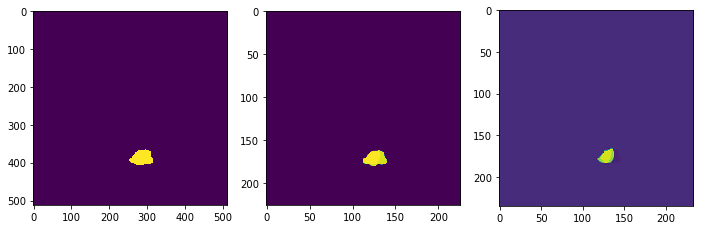

In [375]:
img = sitk.ReadImage(path + '/New_MPS.nii.gz')
img_array = sitk.GetArrayFromImage(img)
img_array = np.swapaxes(img_array,0,2)

ml_array = np.multiply(img_array,img_array==1)
mp_array = np.multiply(img_array,img_array==2)

sku = sitk.ReadImage(path + '/Skull_contour.nii.gz')
sku_array = sitk.GetArrayFromImage(sku)
sku_array = np.swapaxes(sku_array,0,2)

if ConstPixelSpacing != (1,1,1):
    Reshaped_msk = reshape(Mask_array,ConstPixelSpacing)
    Reshaped_img = reshape(ml_array,ConstPixelSpacing)
    Reshaped_mps = reshape(mp_array,ConstPixelSpacing)
    Reshaped_sku = reshape(sku_array,ConstPixelSpacing)
    


else:
    Reshaped_msk = Mask_array
    Reshaped_img = ml_array
    Reshaped_sku = sku_array
    Reshaped_mps = mp_array


#Import ideal midplane parameters
paras = np.load("/Volumes/FAIR/DC-Image-Analysis/DC-project-master/cleancode/NewMidplane/Self_MP_para1_Q.npy",encoding= 'bytes')

# img_gauss = sitk.DiscreteGaussian(img, variance=1)
# display_image(img_gauss,window=120, level=40)

# paras = np.load('/Volumes/FAIR/DC-Image-Analysis/DC-project-master/cleancode/NewMidplane/Final_preop.npy')
file, a, b, c, d = paras[m][0]
# a, b, c, d = a.astype(float),b.astype(float),c.astype(float),d.astype(float)
v = np.array((a,b,c))
v = v.astype(float)
print(file, a, b, c, d, path)

# midplane normal vector regulate the direction
if a<0:
    a,b,c,d = a*-1,b*-1,c*-1,d*-1
n = np.array((a,b,c))

#define rotation axis in plane, in z direction correlates to skew angle
from sympy import *
import sympy
x = sympy.symbols('x')
x1 = solve(a*x + b*100 + c*0 - d, x)
x2 = solve(a*x + b*100 + c*100 - d, x)
k = np.array((x1[0]-x2[0],0,-100)).astype(float)
# k = k/np.sqrt((k[0]**2 + k[1]**2 + k[2]**2))
vk_unit = Functions.unit_vector(k)
vk_unit

## Define rotation axis in y direction, correlating to the orientation angle
x = sympy.symbols('x')
x3 = solve(a*x + b*0.0 + c*100.0- d, x)
x4 = solve(a*x + b*100.0 + c*100.0 - d, x)

k2 = np.array((x3[0]-x4[0],-100.0,0.0)).astype(float)
vk2_unit = Functions.unit_vector(k2)
# the new_vk corresponds to the reshaped version of array, as displayed in ITK
# new_vk = Functions.unit_vector(vk_unit*ConstPixelSpacing)
vk2_unit

#the orientation angle
yaxis = np.array((0,1,0))
angle_ori = Functions.ang(vk2_unit,yaxis)
zaxis = np.array((0,0,1))
# angle_skew = Functions.ang(new_vk,zaxis)
angle_skew = Functions.ang(vk_unit,zaxis)

# Convert to degrees
# The skew angle 
A_S = 180.0 - angle_skew/np.pi*180.0
# The orientation angle
A_O = 180.0 - angle_ori/np.pi*180.0

if vk2_unit[0]*vk2_unit[1] < 0.0:
    A_O = -1*A_O
    
if vk_unit[0]*vk_unit[2] < 0.0:
    A_S = -1*A_S
    
# Calculate the x-coordinate of the miplane, should be a uniform value

# Constant mode rotation, points outside the boundaries of the input 
# are filled with constant 0.0. If points

# ML_array = array
# ideal midplane
Ideal_ML = np.multiply(Reshaped_img >0.2, Reshaped_img)
# mask = active_mask

from scipy.ndimage.interpolation import rotate
r_IML = rotate(Reshaped_img,A_O,mode='constant',axes=(0,1))
r2_IML = rotate(r_IML,A_S,mode='constant',axes=(0,2))

r_mps = rotate(Reshaped_mps,A_O,mode='constant',axes=(0,1))
r2_mps = rotate(r_mps,A_S,mode='constant',axes=(0,2))

binary_mps = np.multiply(r2_mps,r2_mps > 0.1)

r_mask = rotate(Reshaped_msk,A_O,mode='constant',axes=(0,1))
r2_mask = rotate(r_mask,A_S,mode='constant',axes=(0,2))

r_sku = rotate(Reshaped_sku,A_O,mode='constant',axes=(0,1))
r2_sku = rotate(r_sku,A_S,mode='constant',axes=(0,2))



i1 = 13
i2 = int((float(i1)/Mask_array.shape[2])*r2_mask.shape[2])

plt.figure(figsize=(16,5))
plt.subplot(141)
plt.imshow(Mask_array[:,:,i1])

plt.subplot(142)
plt.imshow(Reshaped_msk[:,:,i2])

plt.subplot(143)
plt.imshow(r2_mask[:,:,i2])
plt.show()


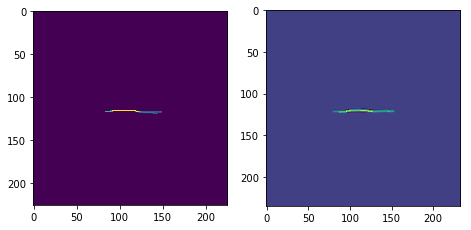

In [376]:
i = 105

plt.figure(figsize=(16,5))
plt.subplot(141)

# plt.imshow(mask[:,i,:]
plt.imshow(Reshaped_mps[:,:,i])
plt.subplot(142)
plt.imshow(r2_mps[:,:,i])
plt.show()

In [377]:
# When finding the binary mask, try to look somewhere around the average value
# make sure Binary_mask is not too coarse than the original mask
r2_mps.mean()

0.0031280333636726958

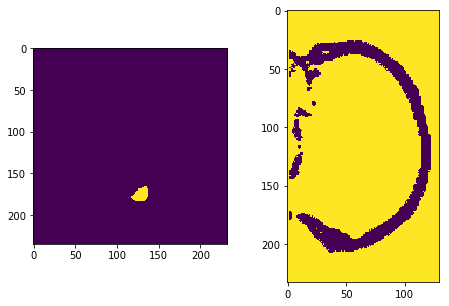

In [378]:
Binary_Mask = np.zeros(r2_mask.shape)
Binary_Mask[np.abs(r2_mask)>0.2]=1

Binary_sku  = np.zeros(r2_sku.shape)
Binary_sku[np.abs(r2_sku)>0.05] = -1

# Check the spread range of x1 value should be very small
# Calculate the reference_x coordinates
Binary_mp = np.zeros(r2_IML.shape)
Binary_mp[np.abs(r2_IML)>0.4]=1
r2_IMLq = Binary_mp
xr = np.nonzero(r2_IMLq)[0]
counts = np.bincount(xr)
reference_x = np.argmax(counts)

Skull_Contour = Binary_sku[reference_x,:,:]


plt.figure(figsize=(16,5))
plt.subplot(141)
plt.imshow(Binary_Mask[:,:,i2])

plt.subplot(142)
plt.imshow(Binary_sku[reference_x,:,:])



In [379]:
midplane_split = np.zeros(r2_IMLq.shape)
for i in range(reference_x-1,r2_IMLq.shape[0]):
    midplane_split[i,:,:] = 1

Left_mask = np.multiply(Binary_Mask,midplane_split==0)
Right_mask = np.multiply(Binary_Mask,midplane_split==1)

Left_sum = np.sum(Left_mask,0)
Right_sum = np.sum(Right_mask,0)
H_diff = Left_sum-Right_sum

y,z = np.nonzero(H_diff)
lesion_contour = Skull_Contour.copy()

for i in range(len(z)):
#     Skull_Contour[z[i]-1,y[i]-1]= H_diff[z[i]-1,y[i]-1]
    lesion_contour[y[i]-1,z[i]-1]= H_diff[y[i]-1,z[i]-1]

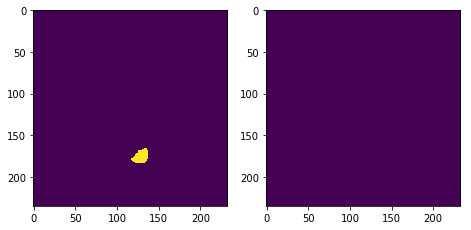

In [380]:
# View the rotation from axial plane


plt.figure(figsize=(16,5))
plt.subplot(141)
plt.imshow(Right_mask[:,:,i2])
plt.subplot(142)
plt.imshow(Left_mask[:,:,i2])


plt.show()

<IPython.core.display.Javascript object>


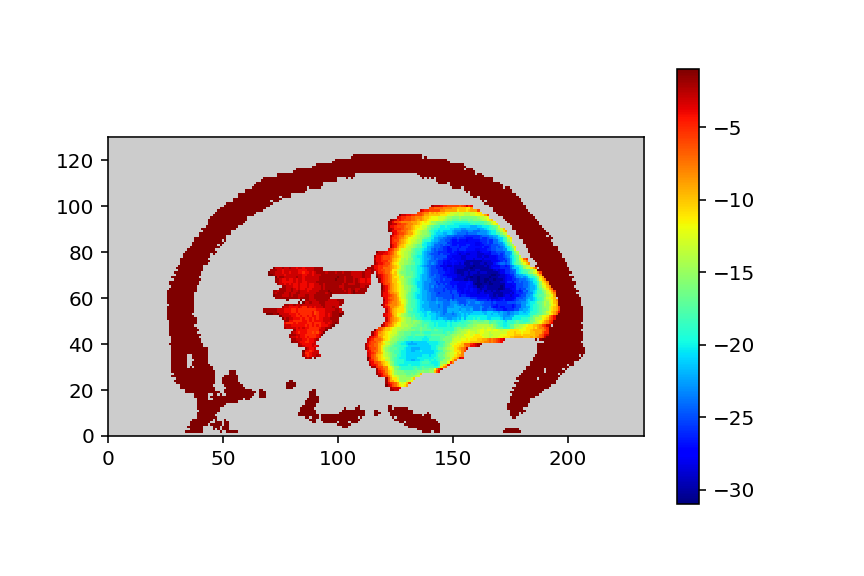

In [381]:
%matplotlib nbagg
fig, ax = plt.subplots()
lesion_contour[lesion_contour==0]=np.nan
palette = plt.cm.jet
palette.set_bad(alpha=0.2)
# heatmap = ax.imshow(mps_contour.transpose(), cmap=palette)
heatmap = ax.imshow(lesion_contour.transpose(), cmap=palette)
# heatmap = ax.pcolor(brain_diff==0, cmap=plt.cm.winter)
plt.ylim(0, Skull_Contour.shape[1])
plt.xlim (0,Skull_Contour.shape[0])
# ax.set_aspect(ConstPixelSpacing[2]/ConstPixelSpacing[1])
plt.colorbar(heatmap)
plt.show()

os.chdir(path)
plt.savefig('lesion_contour.png')

## MPS using rotation of the mps

In [382]:
# coord_list = []
# dic = {}
# for i in range(len(dis[0])):
#     if (dis[1][i],dis[2][i]) in coord_list:
#         dic[(dis[1][i],dis[2][i])].append((dis[0][i]))
#     else:
#         coord_list.append((dis[1][i],dis[2][i]))
#         dic[(dis[1][i],dis[2][i])] = [dis[0][i]]

# # in dis, there might be overlapping coordinates in MPS plane due to the rotation effects
# # get the mean value of those overlapping keys

# for i in coord_list:
   
#     MPS_metrix[i] = np.mean(dic[i]) - reference_x


Binary_mps = np.zeros(r2_mps.shape)
Binary_mps[np.abs(r2_mps)>0.03]=1
print('number of MPS points:',len(Binary_mps[0]))

dis = np.nonzero(Binary_mps)
MPS_metrix = np.zeros(Binary_mps.shape[:2])
MPS_metrix_normalized = np.zeros(Binary_mps.shape[:2])

# max_dev = float(np.max(np.abs(dis[0]-reference_x)))

coord_list = []
dic = {}
for i in range(len(dis[0])):
    if (dis[1][i],dis[2][i]) in coord_list:
        dic[(dis[1][i],dis[2][i])].append((dis[0][i]))
    else:
        coord_list.append((dis[1][i],dis[2][i]))
        dic[(dis[1][i],dis[2][i])] = [dis[0][i]]

# in dis, there might be overlapping coordinates in MPS plane due to the rotation effects
# get the mean value of those overlapping keys

for i in coord_list:
    MPS_metrix[i] = np.mean(dic[i]) - reference_x

number of MPS points: 233


In [383]:
np.sum(MPS_metrix[MPS_metrix>0]),np.sum(MPS_metrix[MPS_metrix<0])

(412.24761904761897, -45497.153571428571)

In [384]:
np.sum(MPS_metrix>0),np.sum(MPS_metrix<0)

(605, 10816)

In [385]:
# Deviation to the right is positive!
# if np.sum(MPS_metrix>0) > np.sum(MPS_metrix<0):
if np.sum(MPS_metrix[MPS_metrix>0]) > np.sum(np.abs(MPS_metrix[MPS_metrix<0])):
    print('inaccuracy:', np.min(MPS_metrix))
    MPS_metrix[MPS_metrix < 0] = 0.01
    print("Midplane shift to the right hemisphere")
else:
    MPS_metrix = MPS_metrix * -1
    MPS_metrix[MPS_metrix < 0] = 0.01
    print("Midplane shift to the left hemisphere")
    
MPS_metrix_normalized = MPS_metrix/np.nanmax(MPS_metrix)
print('Average MPS length:', np.mean(MPS_metrix),'\n'
     'Max MPS deviation:', np.nanmax(MPS_metrix),'\n'
     'MPS_volume:', np.nansum(MPS_metrix)
     )

MPS_metrix[MPS_metrix==0.] = np.nan
# MPS_metrix_normalized[MPS_metrix_normalized==0.] = np.nan

import scipy
# ww[ww==0] = np.nan
ww = scipy.ndimage.filters.gaussian_filter(MPS_metrix_normalized,0.5)
ww[ww==0] = np.nan

Skull_Contour[np.nonzero(Skull_Contour)] = -0.2
mps_contour = ww.copy()
y,z = np.nonzero(Skull_Contour)
for i in range(len(z)):
    mps_contour[y[i]-1,z[i]-1]= Skull_Contour[y[i]-1,z[i]-1]

Midplane shift to the left hemisphere
Average MPS length: 0.83103284762 
Max MPS deviation: 14.5 
MPS_volume: 45503.2035714


In [386]:
np.nanmax(MPS_metrix),np.nanmin(MPS_metrix)

(14.5, 0.01)

<IPython.core.display.Javascript object>


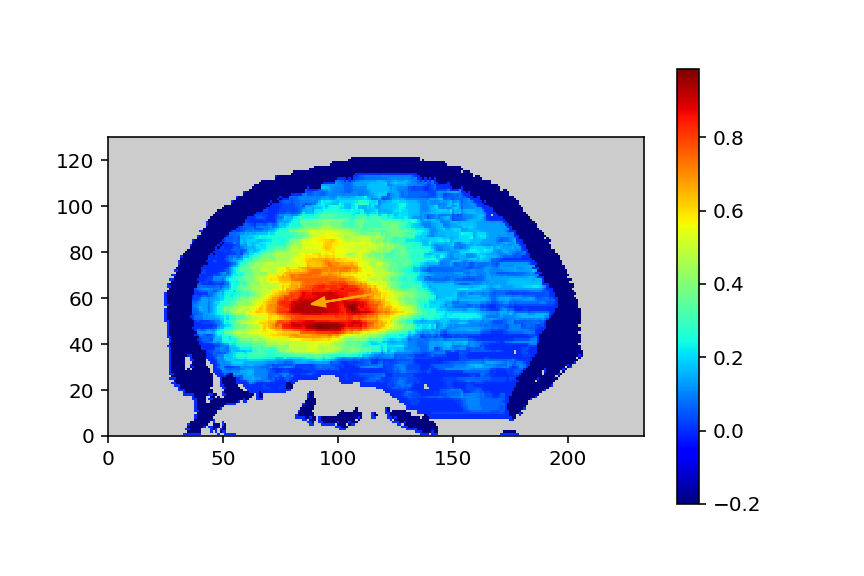

In [387]:
%matplotlib nbagg
fig, ax = plt.subplots()
lesion_contour[lesion_contour==0]=np.nan
palette = plt.cm.jet
palette.set_bad(alpha=0.2)
heatmap = ax.imshow(mps_contour.transpose(), cmap=palette)
# heatmap = ax.imshow(lesion_contour.transpose(), cmap=palette)
# heatmap = ax.imshow(Skull_Contour.transpose())

plt.ylim(0, Skull_Contour.shape[1])
plt.xlim (0,Skull_Contour.shape[0])
# ax.set_aspect(ConstPixelSpacing[2]/ConstPixelSpacing[1])
plt.colorbar(heatmap)
plt.show()

os.chdir(path)
plt.savefig('mps_contour.png')

# Metrics

In [388]:
from skimage import filters
import scipy.ndimage as ndi
from skimage.segmentation import find_boundaries as boundaries
import skimage

def region_parameter(region):
    #     Output the region parameters including centroid coordinate, 
    #     region area, length of major and minor axis
    labels = skimage.measure.label(region, connectivity=1)
    props = skimage.measure.regionprops(labels)
    v = [p.area for p in props]
    ind = np.argsort(v)
    # # From first to fourth biggest region
    #   determine whether the regions are connected or not
    n_regions = len(v)
    vcoords = props[ind[-1]].coords
    Area = v[ind[-1]]
    V_centroid = props[ind[-1]].centroid

    # The length of the major axis of the ellipse that has the same 
    # normalized second central moments as the region
    axis_major = props[ind[-1]].major_axis_length
    axis_minor = props[ind[-1]].minor_axis_length
    return n_regions,Area,V_centroid,axis_major,axis_minor

def average(xs):
    N = float(len(xs))
    return tuple(sum(col)/N for col in zip(*xs))

MPS = ww
# Region of relative MPS greater than 0.6
region06 = np.zeros(MPS.shape)
region06[MPS>0.6] = 1

# Region of relative MPS greater than 0
region0 = np.zeros(MPS.shape)
region0[MPS>0] = 1

# Region of relative MPS greater than 0.8
region08 = np.zeros(MPS.shape)
region08[MPS>0.8] = 1

# Region of relative MPS greater than 0.8
region04 = np.zeros(MPS.shape)
region04[MPS>0.4] = 1

n,Area0,Centroid0,axis_major0,axis_minor0 = region_parameter(region0)
n,Area4,Centroid4,axis_major4,axis_minor4 = region_parameter(region04)
n,Area6,Centroid6,axis_major6,axis_minor6 = region_parameter(region06)
n,Area8,Centroid8,axis_major8,axis_minor8 = region_parameter(region08)

maxMPS = np.where(ww==np.nanmax(ww))[0][0],np.where(ww==np.nanmax(ww))[1][0]



# Vectors pointing from centroid of brain to centroid of cross plane deviation
mps_centroid = average([Centroid4,Centroid6,Centroid8])

vec1 = np.subtract(mps_centroid,Centroid0)
# vec1 pointing tawards the centroid of midplane deviation
vec2 = np.subtract(maxMPS,Centroid0)
# vec2 pointing towards the max MPS deviation point


import matplotlib
x,y = Centroid0
dx,dy = vec1
wx,wy = vec2

matplotlib.pyplot.arrow(x, y, dx, dy,head_width=4,color = 'orange')


# Specify vec1 or vec2

/anaconda/envs/mic3/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in greater
/anaconda/envs/mic3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/anaconda/envs/mic3/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in greater
/anaconda/envs/mic3/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in greater


<IPython.core.display.Javascript object>


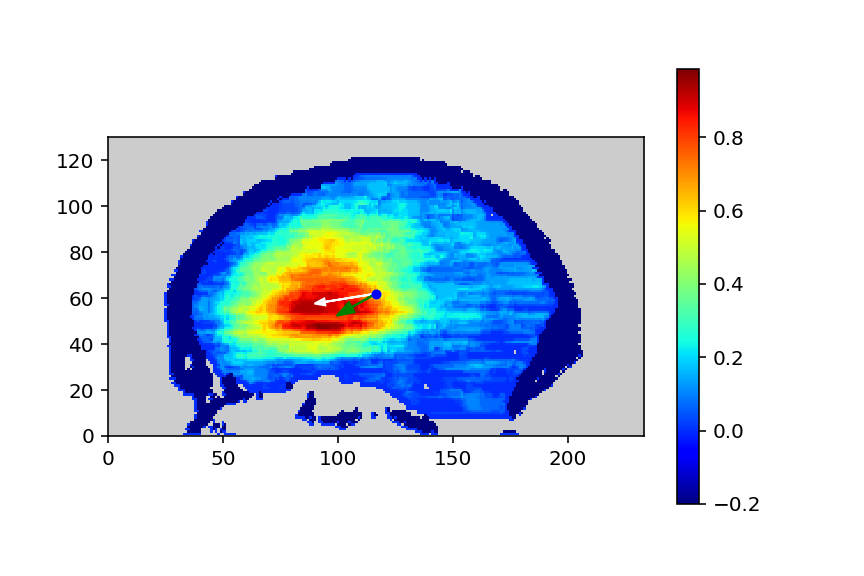

In [395]:
%matplotlib nbagg
fig, ax = plt.subplots()
palette = plt.cm.jet
palette.set_bad(alpha=0.2)
Skull_Contour[Skull_Contour==0]= np.nan
heatmap = ax.imshow(mps_contour.transpose(), cmap=palette)
# matplotlib.pyplot.arrow(x, y, dx, dy,head_width=4)
# matplotlib.pyplot.arrow(x, y, dx, dy,head_width=4)

matplotlib.pyplot.arrow(x, y, dx, dy,head_width=3,color = 'white')
# white towards centroid of MPS deviation
# green towards max MPS point
matplotlib.pyplot.arrow(x, y, wx, wy,head_width=5,color = 'green')


plt.plot([x], [y], marker='o', markersize=4, color="blue")

# heatmap = ax.imshow(lesion_contour.transpose(), cmap=palette)
# heatmap = ax.pcolor(brain_diff==0, cmap=plt.cm.winter)
plt.ylim(0, Skull_Contour.shape[1])
plt.xlim (0,Skull_Contour.shape[0])
# ax.set_aspect(ConstPixelSpacing[2]/ConstPixelSpacing[1])
plt.colorbar(heatmap)
plt.show()
# plt.ion()

In [390]:
os.chdir(path)
plt.savefig('mps_vecs.png')

In [391]:
vec1, vec2

(array([-22.20477388,  -3.6057751 ]), array([-10.50398724,  -5.92640693]))

In [392]:
# axis_pair8,axis_pair6,axis_pair4,axis_pair0 = [],[],[],[]
# area8,area6,area4,area0 =  [],[],[],[]
# maxMPS_list, centroidMPS_list,centroid_Brain = [], [],[]
# vec1_list, vec2_list = [], []
# volume = []

volume.append((np.nansum(MPS_metrix)))
vec1_list.append((vec1))
vec2_list.append((vec2))
centroid_Brain.append((Centroid0))
centroidMPS_list.append((mps_centroid))
maxMPS_list.append((maxMPS))
area8.append((Area8))
area6.append((Area6))
area4.append((Area4))
area0.append((Area0))

axis_pair8.append((axis_major8,axis_minor8))
axis_pair6.append((axis_major6,axis_minor6))
axis_pair4.append((axis_major4,axis_minor4))
axis_pair0.append((axis_major0,axis_minor0))



In [393]:
output = {'Area80%': area8, 'Area60%': area6,'Area40%':area4, 'Area_crossbrain':area0,
         'axis_80%':axis_pair8,'axis_60%':axis_pair6,'axis_40%':axis_pair4,'axis_0%':axis_pair0,
          'maxMPS_coord':maxMPS_list, 'centroidMPS_coord':centroidMPS_list,'centroid_Brain_coord':centroid_Brain,
          'mps_centroid_vec':vec1_list, 'max_mps_vec':vec2_list,'mps_volume':volume
         }
output

{'Area40%': [1838,
  3158,
  2764,
  2362,
  2097,
  4004,
  3422,
  3711,
  3823,
  2164,
  2120,
  3120,
  3035],
 'Area60%': [771,
  2015,
  1565,
  741,
  832,
  2033,
  1804,
  2482,
  2089,
  1089,
  863,
  1503,
  1461],
 'Area80%': [184, 795, 606, 64, 106, 391, 519, 732, 556, 330, 251, 280, 580],
 'Area_crossbrain': [14283,
  14040,
  18503,
  18212,
  15220,
  18733,
  17837,
  18852,
  14145,
  15742,
  18520,
  18902,
  13167],
 'axis_0%': [(165.35794680372015, 121.71243104929258),
  (155.01747538611767, 119.49050455472127),
  (178.28753573423043, 139.00963184785084),
  (183.4399251732889, 131.24083316323612),
  (166.57328639729528, 122.75359870142958),
  (184.1402406764204, 137.51323478794717),
  (186.34072261282498, 125.56087228296599),
  (189.71136539087303, 131.26263367687773),
  (153.1822064481501, 123.37843099353906),
  (161.0201841107354, 128.97321735665815),
  (171.5434371893866, 143.12861148042282),
  (181.84456335900663, 137.4618542881476),
  (164.3024609510651, 10

In [401]:
import pandas as pd
longlist = pd.DataFrame(data = output)

In [399]:
pd.DataFrame(data = output).to_csv('MPS_metrix.csv')

<IPython.core.display.Javascript object>


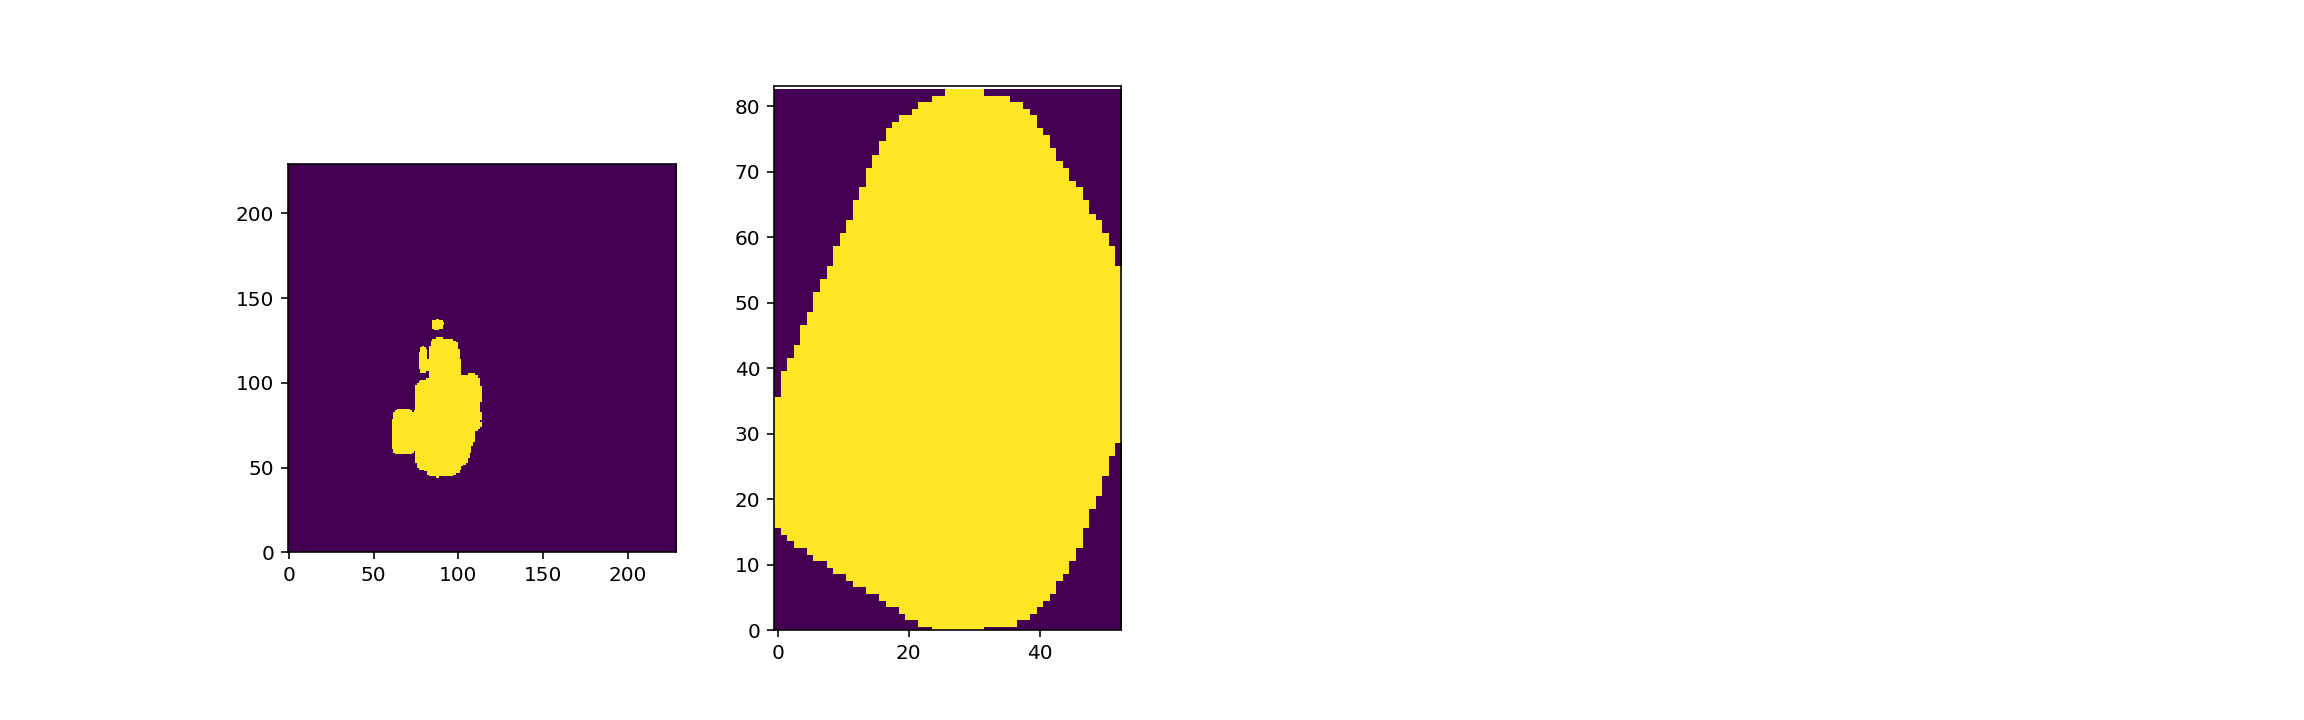

In [441]:
ROI = region04
labels = skimage.measure.label(ROI, connectivity=1)
props = skimage.measure.regionprops(labels)
v = [p.area for p in props]
ind = np.argsort(v)
# # From first to fourth biggest region
vcoords = props[ind[-1]].coords
Area = v[ind[-1]]
V_centroid = props[ind[-1]].centroid

# The length of the major axis of the ellipse that has the same 
# normalized second central moments as the region
axis_major = props[ind[-1]].major_axis_length
axis_minor = props[ind[-1]].minor_axis_length
convex = props[ind[-1]].convex_image

plt.figure(figsize=(16,5))
plt.subplot(141)
plt.imshow(ROI)
plt.ylim(0, ROI.shape[0])
plt.subplot(142)
plt.ylim(0, convex.shape[0])
plt.imshow(convex)

In [399]:
# attempts to interpolate the hole in the middle, turns out not functioning probably because the whole is two big
# import scipy
# coords = (np.array(ylist),np.array(zlist))
# y = np.nonzero(MPS_metrix_normalized)[0]
# z = np.nonzero(MPS_metrix_normalized)[1]
# gy = np.arange(min(y),max(y)+1)
# gz = np.arange(min(z),max(z)+1)

# ylist = []
# zlist = []

# for i in gy:
#     for j in gz:
#         ylist.append((i))
#         zlist.append((j))

# dis_linear = scipy.interpolate.griddata(coords,MPS_metrix_normalized[coords],coords,method='nearest')
# dis_linear == MPS_metrix_normalized[coords]
# MPS_metrix_normalized[coords] = dis_linear

In [404]:

for i in longlist['mps_centroid_vec']:
    print(i)

[-44.4332285    9.21683423]
[-20.1038939    4.84014783]
[-20.18249883   0.86235913]
[-10.06990011  24.09144373]
[-17.82673402  16.26018346]
[-35.36644988  18.4561816 ]
[-22.58274007  -1.49568484]
(-25.007485912939515, 1.3614169453984601)
[-17.78573358   4.95239308]
[-19.99953015   4.29113374]
[-18.21343931   3.83859707]
[-7.45982549 -3.56035831]
[-22.20477388  -3.6057751 ]


<IPython.core.display.Javascript object>


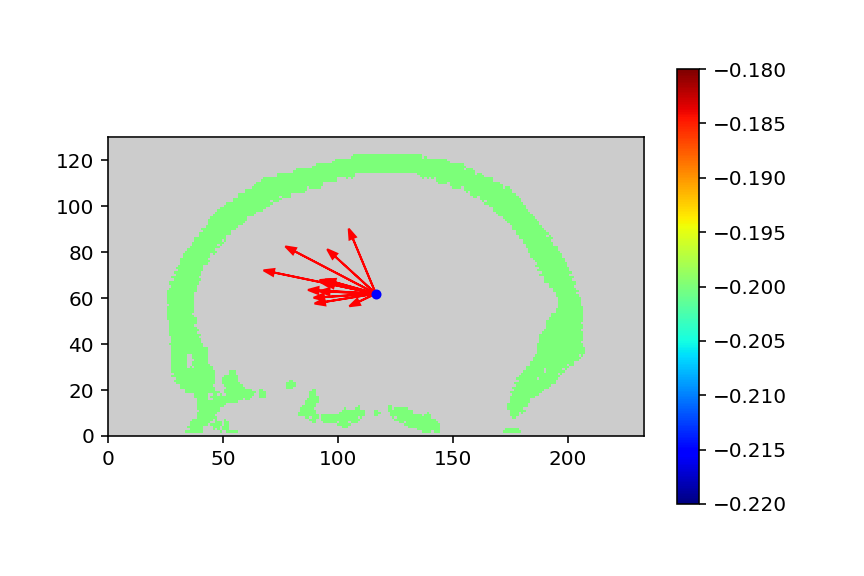

In [406]:
%matplotlib nbagg
fig, ax = plt.subplots()
palette = plt.cm.jet
palette.set_bad(alpha=0.2)
Skull_Contour[Skull_Contour==0]= np.nan
heatmap = ax.imshow(Skull_Contour.transpose(), cmap=palette)
# matplotlib.pyplot.arrow(x, y, dx, dy,head_width=4)
# matplotlib.pyplot.arrow(x, y, dx, dy,head_width=4)

for i in longlist['mps_centroid_vec']:
    matplotlib.pyplot.arrow(x, y, i[0], i[1],head_width=3,color = 'red')
# white towards centroid of MPS deviation
# green towards max MPS point
# matplotlib.pyplot.arrow(x, y, wx, wy,head_width=5,color = 'green')


plt.plot([x], [y], marker='o', markersize=4, color="blue")

# heatmap = ax.imshow(lesion_contour.transpose(), cmap=palette)
# heatmap = ax.pcolor(brain_diff==0, cmap=plt.cm.winter)
plt.ylim(0, Skull_Contour.shape[1])
plt.xlim (0,Skull_Contour.shape[0])
# ax.set_aspect(ConstPixelSpacing[2]/ConstPixelSpacing[1])
plt.colorbar(heatmap)
plt.show()
# plt.ion()

In [47]:
import scipy
import scipy.io
os.chdir(path)
scipy.io.savemat('Contours.mat',{'Skull_contour':Skull_Contour,'lesion_contour':lesion_contour})

In [14]:
os.chdir(path)
plt.savefig('lesion_heatmap.png')

NameError: name 'path' is not defined

In [296]:
Skull_Contour.shape

(239, 190)

In [306]:
Skull_Contour[Skull_Contour!=]

array([ nan,  nan,  nan, ...,  nan,  nan,  nan])

In [312]:
np.mean(np.nonzero(Skull_Contour),1)

array([ 119. ,   94.5])

In [7]:
import scipy
import scipy.io

MPS_array = scipy.io.loadmat('/Volumes/FAIR/Eric_Midlinedeliniation/Self-MPS/SDH16-2/MPS1.mat')['mm']

In [12]:
y = MPS_array[0]
z = MPS_array[1]
dis = MPS_array[2]